In [27]:
from explainability.structured.core.structured_challenger import SKChallenger
from explainability.structured.core.structured_manipulator import StructuredManipulator
from explainability.structured.samples.challengers.categorize_challenger import CategorizeChallenger
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from interpret.blackbox import ShapKernel

In [2]:
# Load adult income dataset, 100 rows
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None, nrows=1000)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry",
    "Income"
]
df.drop([
    "fnlwgt", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race",
    "NativeCountry"
], axis=1, inplace=True)
label_column = "Income"

# Sample Challenger

In [4]:
# challenger that creates three challenge, each randomly choosing a numeric column to bin
cc = CategorizeChallenger(DecisionTreeClassifier(max_depth=3),
                          df, label_column)

In [5]:
# creates multiple structured manipulators, one for each predefined challenge
cc.generate_challenges()

In [6]:
# base contains the original dataset, which is always included in a challenge
cc.challenges["base"].df.head()

,Age,WorkClass,Education,Gender,CapitalGain,CapitalLoss,HoursPerWeek,Income
0,26,Local-gov,Bachelors,Male,1055,0,40,<=50K
1,17,?,11th,Male,0,0,40,<=50K
2,34,Private,HS-grad,Male,0,0,35,>50K
3,23,Private,HS-grad,Female,0,0,35,<=50K
4,27,Local-gov,Masters,Male,0,0,35,<=50K


In [7]:
# an example of a challenge dataset
cc.challenges["challenge_2"].df.head()

,Age,WorkClass,Education,Gender,CapitalGain,CapitalLoss,HoursPerWeek,Income
0,"(17.0, 53.5]",Private,5th-6th,Male,0,0,40,<=50K
1,"(17.0, 53.5]",Private,HS-grad,Female,0,0,40,<=50K
2,"(17.0, 53.5]",Private,Assoc-acdm,Female,0,0,36,<=50K
3,"(17.0, 53.5]",Private,HS-grad,Female,0,0,38,<=50K
4,"(17.0, 53.5]",Self-emp-not-inc,Bachelors,Male,0,0,60,>50K


In [8]:
# trains one of our models for each challenge
cc.train_models()

In [9]:
# Evaluate base model
_, _, X_test, y_test = cc.challenges["base"].train_test_split()
cc.models["base"].score(X_test, y_test)

0.8

In [10]:
# Evaluate a challenge model
_, _, X_test, y_test = cc.challenges["challenge_2"].train_test_split()
cc.models["challenge_2"].score(X_test, y_test)

0.845

In [15]:
X_train, y_train, X_test, y_test = cc.challenges["challenge_2"].train_test_split()
cc.models["challenge_2"].named_steps["preprocessor"].fit_transform(X_train)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.28514388e-01, -2.21898312e-01,  1.06785025e-03],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.28514388e-01, -2.21898312e-01,  1.06785025e-03],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.28514388e-01, -2.21898312e-01, -3.40644231e-01],
       ...,
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.28514388e-01, -2.21898312e-01,  1.70962826e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.28514388e-01, -2.21898312e-01,  1.06785025e-03],
       [ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -2.28514388e-01, -2.21898312e-01,  1.06785025e-03]])

In [23]:
from sklearn.preprocessing import LabelEncoder

X_train, y_train, X_test, y_test = cc.challenges["challenge_2"].train_test_split()

# Note that we have to use a labelencoder for interpretml, as it doesn't like string labels even though sklearn handles them
label_encoder = LabelEncoder().fit(y_train)
# similarly, we need to explicitly apply the preprocessor
pp = cc.models["challenge_2"].named_steps["preprocessor"]

shap = ShapKernel(cc.models["challenge_2"].named_steps["model"], pp.transform(X_train))
shap_local = shap.explain_local(pp.transform(X_test[:5]), label_encoder.transform(y_test[:5]))

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5 [00:00<?, ?it/s]

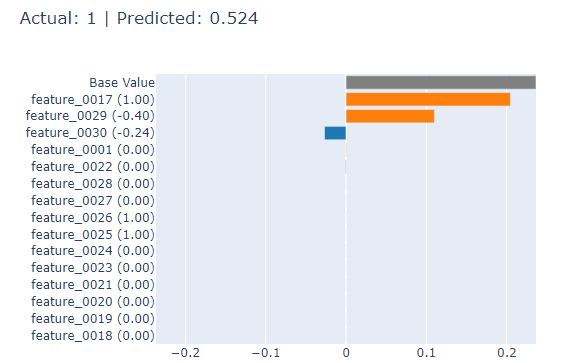

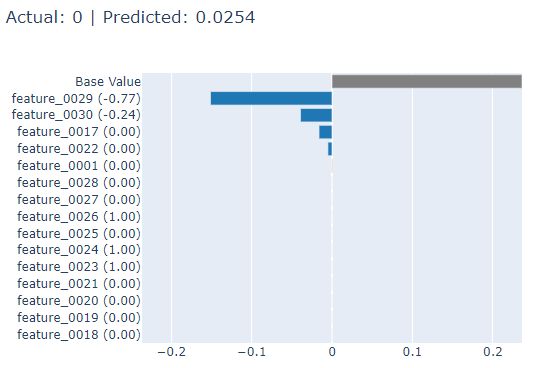

In [24]:
from interpret import show
show(shap_local, 0)

<!-- http://127.0.0.1:7001/2686571409040/ -->

# Custom Challenger

In [25]:
# a custom challenger only needs to implement the `generate_challenges` method

class CustomChallenger(SKChallenger):

    def generate_challenges(self) -> None:
        """
        Generate multiple challenges, each of which consists of duplicating one feature.
        """

        for i in range(2, 5):
            name = f"challenge_{i}"
            sm = StructuredManipulator(self.df, self.label_column, self.random_state)
            sm.duplicate_features()  # randomly picks a column to duplicate
            self.challenges[name] = sm

In [30]:
custom_challenger = CustomChallenger(DecisionTreeClassifier(max_depth=3), df, label_column)
custom_challenger.generate_challenges()
custom_challenger.train_models()

# Evaluate base model
_, _, X_test, y_test = custom_challenger.challenges["base"].train_test_split()
print(custom_challenger.models["base"].score(X_test, y_test))

# Evaluate a challenge model
_, _, X_test, y_test = custom_challenger.challenges["challenge_2"].train_test_split()
print(custom_challenger.models["challenge_2"].score(X_test, y_test))

0.81
0.815
